In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
from pyigrf12 import gridigrf12
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt, convert
import ssusi_utils
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [4]:
mapTime = datetime.datetime( 2015, 1, 5, 5 )#datetime.datetime( 2015, 4, 9, 7 )
vecsTime = datetime.datetime( 2015, 1, 5, 5 )#datetime.datetime( 2015, 4, 9, 5 )
pltCoords = 'mlt'
cntrPotMin = -35.
cntrPotMax = 5.
inpDstList = [-20., -40., -70., -100.]
inpAsyList = [ 14., 37., 71., 105 ] 
sapsProbCutoff = 0.2
delLatDist = 111. * 1e3 # 1 deg lat is 111 km
cntrLevels = numpy.linspace(cntrPotMin, cntrPotMax, 9, endpoint=True)

In [5]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
    # parameters from fitting
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []

for inpDst in inpDstList:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( inpDst )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,inpDst) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= sapsProbCutoff\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,0,-1,0.224959,24,56.0,-20.0
1,1,-1,0.208095,1,56.0,-20.0
2,-2,0,0.278201,22,57.0,-20.0
3,-1,0,0.376660,23,57.0,-20.0
4,0,0,0.397778,24,57.0,-20.0


In [6]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func(asy):
    # parameters from fitting
    a_asy, b_asy = (-6.47, 9.48)
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

# To estimate the boundary we
# fit second order harmonics!
def mlt_fit_func(mlt, asy):
    c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC0 =\
        (0.2099, -0.0014, -1.2449, 0.0033, 0.1377,\
         -0.0001, -0.0082, 0.0028, -0.7931)
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phi0 = (2*numpy.pi/24.) * mlt + phiC0
    cosTerm = c1 * numpy.cos(phi0)
    sinTerm = s1 * numpy.sin(phi0)
    cos2Term = c2 * numpy.cos(2*phi0)
    sin2Term = s2 * numpy.sin(2*phi0)
    return cosTerm + sinTerm + cos2Term + sin2Term

# MLAT varies with MLT and ASY. So we
# record MLAT variations as functions of
# MLT and Asy as well.
def mlat_mlt_fit_func(mlat, normMLT, asy):
    c0_a, c0_b, c0_c, c1_a, c1_b,\
        c1_c, c2_a, c2_b, c2_c = (0.04777, 0.00053,\
                0.00623, 0.85795, 0.00688, 0.06158,\
                0.07129, -0.00795, -0.07779)
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    c2 = c2_a + c2_b * asy + c2_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

def saps_pot_func( asy, mlt, mlat ):
    # Estimate SAPS potentials by
    # combining all the different 
    # functions.
    normMLT = mlt
    if mlt > 12.:
        normMLT = mlt - 24.
    phiSaps = peak_pot_fit_func(asy)
#     print "phiSaps", phiSaps
    mltSaps = mlt_fit_func(mlt, asy)
#     print "mltSaps", mltSaps
    mlatMLTSaps = mlat_mlt_fit_func(mlat, normMLT, asy)
#     print "mlat-mlt-Saps", mlatMLTSaps
    return -1.*phiSaps*mltSaps*mlatMLTSaps

In [7]:
predPotArr = []
predMlatArr = []
predMltArr = []
predNormMltArr = []
predAsyArr = []

for indAsy, inpAsy in enumerate(inpAsyList):
    for cpMLT in range(1,25):
        if cpMLT > 12.:
            currNormMlt = cpMLT - 24.
        else:
            currNormMlt = cpMLT
        currMLTMlats = sapsPredDF[ (sapsPredDF["normMLT"]\
                                  == currNormMlt) & (sapsPredDF["dst_index"]\
                                  == inpDstList[indAsy])\
                                 ]["Lat"].values
#         currMLTMlatsMin = sapsPredDF[ (sapsPredDF["normMLT"]\
#                                   == currNormMlt) & (sapsPredDF["dst_index"]\
#                                   == inpDstList[indAsy])\
#                                  ]["Lat"].min()
#         currMLTMlatsMax = sapsPredDF[ (sapsPredDF["normMLT"]\
#                                       == currNormMlt) & (sapsPredDF["dst_index"]\
#                                       == inpDstList[indAsy])\
#                                      ]["Lat"].max()
#         currMLTMlats = numpy.arange( currMLTMlatsMin, currMLTMlatsMax + 0.5, 0.5 )
    #     print cpMLT, currMLTMlats
        if currMLTMlats.shape[0] <= 3:
            continue
        # get normalized latitudes
        normMLTMLATs = currMLTMlats - numpy.min( currMLTMlats )
        normMLTMLATs = normMLTMLATs/numpy.max( normMLTMLATs )
        for indNorm, currNormMLAT in enumerate(normMLTMLATs):
            predPotArr.append( saps_pot_func(inpAsy, cpMLT, currNormMLAT) )
            predMlatArr.append( currMLTMlats[indNorm] )
            predAsyArr.append( inpAsy )
            predNormMltArr.append( currNormMlt )
            predMltArr.append(cpMLT)
    
predPotDF = pandas.DataFrame({
                "potential" : predPotArr,
                "Lat" : predMlatArr,
                "AsyH" : predAsyArr,
                "normMLT" : predNormMltArr,
                "MLT" : predMltArr
                })
predPotDF = predPotDF.drop_duplicates()
predPotDF["Mlon"] = convert_mlt( predPotDF["MLT"].values, vecsTime , m2a=True )
predPotDF["date"] = vecsTime

predPotDF.head()

,AsyH,Lat,MLT,normMLT,potential,Mlon,date
0,14.0,56.0,1,1.0,-0.923504,13.812952,2015-01-05 05:00:00
1,14.0,57.0,1,1.0,-3.907496,13.812952,2015-01-05 05:00:00
2,14.0,58.0,1,1.0,-6.749790,13.812952,2015-01-05 05:00:00
3,14.0,59.0,1,1.0,-9.450385,13.812952,2015-01-05 05:00:00
4,14.0,60.0,1,1.0,-12.009282,13.812952,2015-01-05 05:00:00


In [8]:
def get_geo_coords(row):
    glat, glon = convert( row["Lat"], row["Mlon"] , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

predPotDF["gcoord"] = predPotDF.apply( get_geo_coords, axis=1 )
predPotDF["glat"] = [ float( x.split("__")[0] ) for x in predPotDF["gcoord"] ]
predPotDF["glon"] = [ float( x.split("__")[1] ) for x in predPotDF["gcoord"] ]
predPotDF.head()

,AsyH,Lat,MLT,normMLT,potential,Mlon,date,gcoord,glat,glon
0,14.0,56.0,1,1.0,-0.923504,13.812952,2015-01-05 05:00:00,47.4067904073__-67.1978168495,47.406790,-67.197817
1,14.0,57.0,1,1.0,-3.907496,13.812952,2015-01-05 05:00:00,48.4281324547__-67.2792524407,48.428132,-67.279252
2,14.0,58.0,1,1.0,-6.749790,13.812952,2015-01-05 05:00:00,49.4492217248__-67.3622631643,49.449222,-67.362263
3,14.0,59.0,1,1.0,-9.450385,13.812952,2015-01-05 05:00:00,50.4704042503__-67.4473481846,50.470404,-67.447348
4,14.0,60.0,1,1.0,-12.009282,13.812952,2015-01-05 05:00:00,51.4920285763__-67.5350576623,51.492029,-67.535058


In [9]:
# We'll model azimuths based on the equations we developed
def azim_fit_func(delMLT, asy):
    if (asy >= 0) & (asy < 30):
        slope, intrcpt = ( -0.24, -84.55 )
    if (asy >= 30) & (asy < 60):
        slope, intrcpt = ( -0.96, -88.1 )
    if (asy >= 60) & (asy < 90):
        slope, intrcpt = ( -1.2, -90.1 )
    if (asy >= 90):
        slope, intrcpt = ( -2.37, -94.4 )
    return intrcpt + slope*delMLT

In [10]:
# Arrays to store potential
potPotArr = []
potVelArr = []
potAzimArr = []
potMltArr = []
potNrmMltArr = []
potMlatArr = []
potMlonArr = []
potEfldArr = []
bFldArr = []
asyArr = []

# we'll adjust the first and last MLTs
# to reduce the velocities. Since the 
# latitudinal extent reduces at the edges
# we see higher velocities
maxNormMLT = predPotDF["normMLT"].max()
minNormMLT = predPotDF["normMLT"].min()
for inpAsy in inpAsyList:
    for cmlt in predPotDF["normMLT"].unique().tolist():
        # Get Uniq Lats at the MLT!
        selMltDF = predPotDF[ (predPotDF["normMLT"] == cmlt) &\
                            (predPotDF["AsyH"] == inpAsy) ]
        if selMltDF.shape[0] < 2:
            continue
        # At each MLT we assume potential is zero at the lowest
        # latitude!
        if cmlt < 0:
            actMLT = cmlt + 24.
        else:
            actMLT = cmlt
        #numpy.arange( selMltDF["Lat"].max(), selMltDF["Lat"].min()-0.5, -0.5 )
        mlatList = -numpy.sort( -selMltDF["Lat"].unique() )
        delMlats = numpy.gradient(mlatList)
        for mlatInd, cMlat in enumerate( mlatList ):
            if mlatInd + 1 < selMltDF.shape[0]:
                nextLat = mlatList[ mlatInd + 1 ]
                nxtLatsDF = selMltDF[ (selMltDF["Lat"] == nextLat) ]
                nxtLatPot = nxtLatsDF["potential"].values[0]*1e3
            else:
                nxtLatPot = 0.
            selLatsDF = selMltDF[ (selMltDF["Lat"] == cMlat) ]
            currMlon = selLatsDF["Mlon"].values[0]
            currPot = selLatsDF["potential"].values[0]*1e3 # convert to volts from kV
            delPot = currPot - nxtLatPot
            if (cmlt == maxNormMLT) or (cmlt == minNormMLT):
                currEfield = abs(delPot/(delLatDist*1.75)) # In V/m
            else:
                currEfield = abs(delPot/(delLatDist)) # In V/m
            Bx,By,Bz,Bf, yeardec = gridigrf12( selLatsDF["date"].values[0],\
                                        0, 1, 300., selLatsDF["glat"].values[0],\
                                        selLatsDF["glon"].values[0] )
            currVel = currEfield/(Bf[0]*1e-9)
            currAzim = -90.-azim_fit_func( cmlt, inpAsy )
            potVelArr.append( currVel )
            potAzimArr.append( currAzim )
            potPotArr.append( currPot/1e3 )
            potMltArr.append( actMLT )
            potNrmMltArr.append( cmlt )
            potMlatArr.append( cMlat )
            potMlonArr.append( currMlon )
            potEfldArr.append( currEfield*1e3 )
            bFldArr.append(Bf[0])
            asyArr.append( inpAsy )

        
velPotDF = pandas.DataFrame({
            "normMLT" : potNrmMltArr,
            "MLAT" : potMlatArr,
            "MLT" : potMltArr,
            "eSAPS" : potEfldArr,
            "MLON" : potMlonArr,
            "vSAPS" : potVelArr,
            "potential" : potPotArr,
            "AsyH-index" : asyArr,
            "azimSAPS" : potAzimArr,
            "BField" : bFldArr
            })
velPotDF = velPotDF.round(2)
velPotDF.to_csv( "../data/AllAsyBins-vel-pred.csv", index=None, header=None, sep=" " )
feather.write_dataframe(velPotDF, '../data/predVels-AllAsyBins.feather')
velPotDF.head()

,AsyH-index,BField,MLAT,MLON,MLT,azimSAPS,eSAPS,normMLT,potential,vSAPS
0,14.0,48018.78,61.0,13.81,1.0,-5.21,12.44,1.0,-14.43,259.14
1,14.0,47745.24,60.0,13.81,1.0,-5.21,13.17,1.0,-12.01,275.91
2,14.0,47452.74,59.0,13.81,1.0,-5.21,13.90,1.0,-9.45,292.98
3,14.0,47141.47,58.0,13.81,1.0,-5.21,14.63,1.0,-6.75,310.39
4,14.0,46811.65,57.0,13.81,1.0,-5.21,15.36,1.0,-3.91,328.16


In [11]:
velPotDF["endPtMLAT"] = numpy.round( (velPotDF["vSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["MLAT"], 2)
velPotDF["endPtNormMLT"] = numpy.round( (velPotDF["vSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["normMLT"], 2)
velPotDF["endPtMLT"] = [ x + 24. if x < 0. else x for x in velPotDF["endPtNormMLT"] ]
velPotDF["endPtMlon"] = numpy.round( (velPotDF["vSAPS"]/100.) *\
                                numpy.sin( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["MLON"], 2)
velPotDF.head()

,AsyH-index,BField,MLAT,MLON,MLT,azimSAPS,eSAPS,normMLT,potential,vSAPS,endPtMLAT,endPtNormMLT,endPtMLT,endPtMlon
0,14.0,48018.78,61.0,13.81,1.0,-5.21,12.44,1.0,-14.43,259.14,61.02,0.74,0.74,11.23
1,14.0,47745.24,60.0,13.81,1.0,-5.21,13.17,1.0,-12.01,275.91,60.03,0.73,0.73,11.06
2,14.0,47452.74,59.0,13.81,1.0,-5.21,13.90,1.0,-9.45,292.98,59.03,0.71,0.71,10.89
3,14.0,47141.47,58.0,13.81,1.0,-5.21,14.63,1.0,-6.75,310.39,58.03,0.69,0.69,10.72
4,14.0,46811.65,57.0,13.81,1.0,-5.21,15.36,1.0,-3.91,328.16,57.03,0.67,0.67,10.54


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


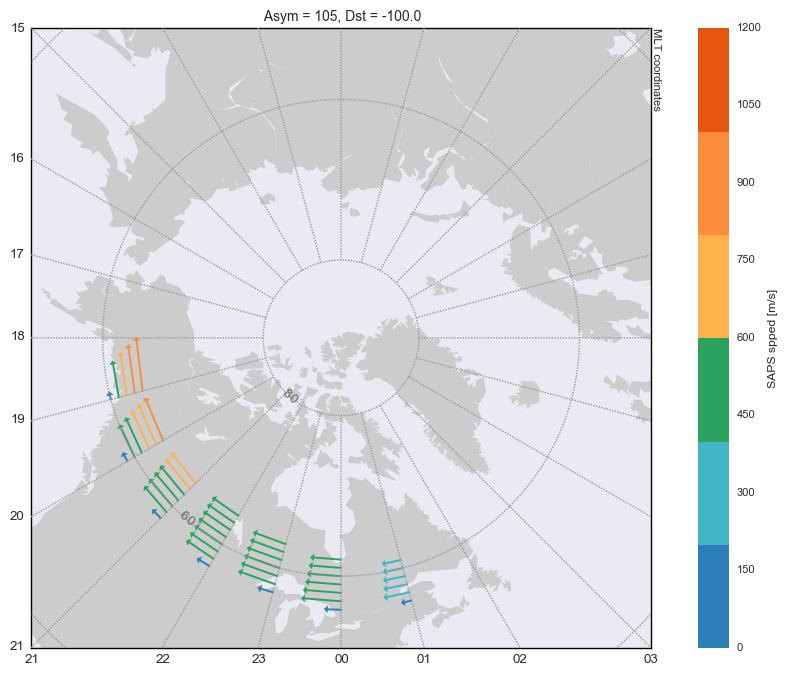

In [12]:
# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(1,1,1)

currVelPotDF = velPotDF[ velPotDF["AsyH-index"] == 14. ]
currVelPotDF["SAPS speed [m/s]"] = currVelPotDF["vSAPS"]
plotMLONends = list( currVelPotDF['endPtMLT'].values * 15. )
plotMLATends = currVelPotDF['endPtMLAT'].tolist()
plotMLONbegins = list( currVelPotDF['MLT'].values * 15. )
plotMLATbegins = currVelPotDF['MLAT'].tolist()
plotVelMagns = currVelPotDF['SAPS speed [m/s]'].tolist()

velScaleMin = 0.
velScaleMax = 1200.

colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
velSeaMap = ListedColormap(sns.color_palette(colors))

m2 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax2, lat_0=90.,\
                            lon_0=0., datetime=mapTime)


colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMlonend, currMLATend, currMlonbgn, currMLATbgn, currVel in\
        zip( plotMLONends, plotMLATends, plotMLONbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = velSeaMap( colNorm(currVel) )
        currXVecBgn, currYVecBgn = m2(currMlonbgn, currMLATbgn, coords=pltCoords)
        currXVecEnd, currYVecEnd = m2(currMlonend, currMLATend, coords=pltCoords)
        velPlot = ax2.plot( [currXVecBgn, currXVecEnd], [ currYVecBgn, currYVecEnd ], color=currCol )     
        ax2.arrow( currXVecBgn, currYVecBgn, currXVecEnd-currXVecBgn, currYVecEnd-currYVecBgn,\
                 head_width=1e5, head_length=5e4, fc=currCol, ec=currCol)

printText = " Asym = " + str(inpAsy) + ", Dst = " + str(inpDst)
ax2.set_title(printText, fontsize=10)
# ax1.text(0.1, 0.9,  printText,
#             transform=ax1.transAxes,
#             color='#2c7fb8', fontsize=8)
# ax1.text(0.1, 0.9,  printText,
#             transform=ax1.transAxes,
#             color='#2c7fb8', fontsize=8)



sm = plt.cm.ScalarMappable(cmap=velSeaMap, norm=Normalize(vmin=velScaleMin, vmax=velScaleMax))
sm._A = []
plt.colorbar(sm, ax=ax2)
sm.colorbar.ax.set_ylabel('SAPS spped [m/s]')
fig.savefig("../figs/pot-vels-allBins.pdf",bbox_inches='tight')

In [21]:
predVelSmryDF = velPotDF[ ["AsyH-index", "normMLT", "vSAPS"] ].groupby( [ "AsyH-index", "normMLT" ] ).median().reset_index()
predVelSmryDF.columns = [ "AsyH-index", "normMLT", "pred_vsaps" ]
print predVelSmryDF

    AsyH-index  normMLT  pred_vsaps
0         14.0     -5.0     695.410
1         14.0     -4.0     628.915
2         14.0     -3.0     555.270
3         14.0     -2.0     481.580
4         14.0     -1.0     544.570
5         14.0      0.0     496.610
6         14.0      1.0     284.445
7         37.0     -5.0     875.530
8         37.0     -4.0     780.590
9         37.0     -3.0     672.225
10        37.0     -2.0     637.795
11        37.0     -1.0     680.000
12        37.0      0.0     714.615
13        37.0      1.0     535.305
14        71.0     -6.0     996.145
15        71.0     -5.0     893.400
16        71.0     -4.0     749.250
17        71.0     -3.0     793.670
18        71.0     -2.0     697.570
19        71.0     -1.0     704.235
20        71.0      0.0     895.995
21       105.0     -7.0     511.200
22       105.0     -6.0     911.690
23       105.0     -5.0     808.595
24       105.0     -4.0     851.160
25       105.0     -3.0     710.690
26       105.0     -2.0     

In [22]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
# Also merge with aymDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH'] ]
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH']
# Divide asymH index into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH', 'AsyH_bin']
mltvSapsDataDF = velsDataDF[ ["normMLT", "AsyH_bin", "vSaps"] \
                    ].groupby( ["normMLT", "AsyH_bin"] ).median().reset_index()

In [33]:
def get_median_values(row):
    if str(row["AsyH_bin"]) == "(0, 30]":
        return 14.
    elif str(row["AsyH_bin"]) == "(30, 60]":
        return 37.
    elif str(row["AsyH_bin"]) == "(60, 90]":
        return 71.
    else:
        return 105.
mltvSapsDataDF["AsyH-index"] = mltvSapsDataDF.apply(get_median_values,axis=1)
modValDF = pandas.merge( mltvSapsDataDF, predVelSmryDF, on=[ "normMLT", "AsyH-index" ] )
modValDF["vel_diff"] = numpy.sqrt( numpy.square( modValDF["pred_vsaps"] - modValDF["vSaps"] ) )

In [34]:
modValDF.head()

,normMLT,AsyH_bin,vSaps,AsyH-index,pred_vsaps,vel_diff
0,-7.0,"(90, 180]",1046.907248,105.0,511.200,535.707248
1,-6.0,"(60, 90]",750.183938,71.0,996.145,245.961062
2,-6.0,"(90, 180]",940.593455,105.0,911.690,28.903455
3,-5.0,"(0, 30]",401.631330,14.0,695.410,293.778670
4,-5.0,"(30, 60]",542.848903,37.0,875.530,332.681097


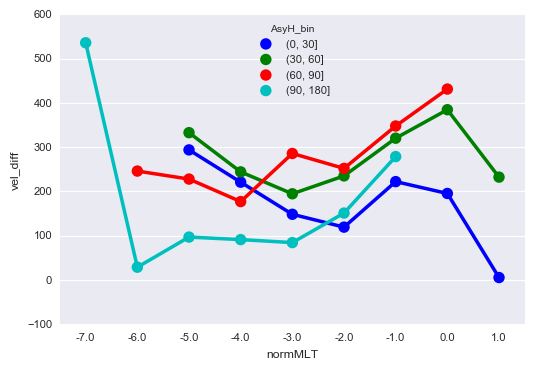

In [35]:
sns.pointplot(x="normMLT", y="vel_diff", hue="AsyH_bin", data=modValDF)